In [1]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')

In [2]:
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
data.card = data.card.replace({"yes": 1, "no": 0})
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure',
             'dependents', 'months', 'majorcards', 'active']
categorical = ['owner', 'selfemp']

In [5]:
from sklearn.model_selection import train_test_split # Importo para entrenar el modelo.

In [6]:
df_full_train, df_test = train_test_split(data, test_size = 0.2, random_state = 1)

In [7]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [8]:
len(df_train),len(df_test),len(df_val)

(791, 264, 264)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [11]:
df_test.head()

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,22.33333,1.8000,0.000667,0.00000,no,no,0,3,0,6
1,0,24.16667,2.8896,0.080178,193.06750,no,no,0,12,0,0
2,0,24.50000,2.3040,0.374743,719.50590,no,no,0,76,1,2
3,0,40.41667,3.1150,0.076759,199.00420,yes,no,1,60,1,11
4,0,30.25000,2.5500,0.035322,74.72667,yes,no,1,11,1,0


In [45]:
auc_scores = []
for c in numerical:
  auc = roc_auc_score(y_train, df_train[c])
  if(auc < 0.5):
    auc = roc_auc_score(y_train, -df_train[c])
  auc_scores.append({'col': c, 'auc': auc.round(3)})

sorted(auc_scores, key = lambda d: d['auc'], reverse=True)

[{'col': 'expenditure', 'auc': 0.991},
 {'col': 'share', 'auc': 0.989},
 {'col': 'reports', 'auc': 0.717},
 {'col': 'active', 'auc': 0.604},
 {'col': 'income', 'auc': 0.591},
 {'col': 'majorcards', 'auc': 0.534},
 {'col': 'dependents', 'auc': 0.533},
 {'col': 'months', 'auc': 0.529},
 {'col': 'age', 'auc': 0.524}]

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [18]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [19]:
import numpy as np

In [49]:
def train(df, y, C=1.0):

  dicts = df[categorical + numerical].to_dict(orient='records')

  dv = DictVectorizer(sparse=False)
  X_train = dv.fit_transform(dicts)

  model = LogisticRegression(C=C, solver='liblinear', max_iter=1000)
  model.fit(X_train, y_train)

  return dv, model


def predict(df, dv, model):

  dicts = df[categorical + numerical].to_dict(orient='records')

  X = dv.transform(dicts)
  y_pred = model.predict_proba(X)[:, 1]

  return y_pred

In [50]:
dv, model = train(df_train, y_train)
y_val_pred = predict(df_val, dv, model)
roc_auc_score(y_val, y_val_pred).round(3)

0.995

AUC for our classifier is: 0.995171242063847


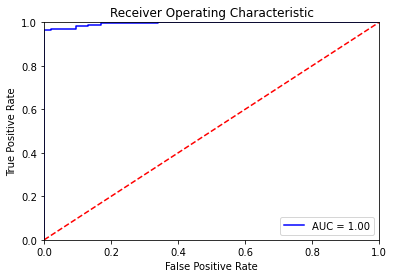

In [51]:
from sklearn.metrics import roc_curve, auc

class_probabilities = model.predict_proba(X_val)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
from sklearn import metrics # Importamos las métricas para calcular los errores del modelo.
import pandas as pd

In [58]:
def confusion_matrix_values(y_true, y_pred, t):

  actual_positive = (y_true == 1)
  actual_negative = (y_true == 0)

  predict_positive = (y_pred >= t)
  predict_negative = (y_pred < t)

  tp = (predict_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()

  precision = (tp / (tp + fp))
  recall = (tp / (tp + fn))

  return (t, tp, fp, tn, fn, precision, recall)

In [59]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
  scores.append(confusion_matrix_values(y_val, y_val_pred, t))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,211,53,0,0,0.799242,1.000000
1,0.01,211,34,19,0,0.861224,1.000000
2,0.02,211,31,22,0,0.871901,1.000000
3,0.03,211,24,29,0,0.897872,1.000000
4,0.04,211,22,31,0,0.905579,1.000000
...,...,...,...,...,...,...,...
96,0.96,204,0,53,7,1.000000,0.966825
97,0.97,203,0,53,8,1.000000,0.962085
98,0.98,203,0,53,8,1.000000,0.962085
99,0.99,202,0,53,9,1.000000,0.957346


In [60]:
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,211,53,0,0,0.799242,1.000000
10,0.1,210,17,36,1,0.925110,0.995261
20,0.2,207,5,48,4,0.976415,0.981043
30,0.3,205,5,48,6,0.976190,0.971564
40,0.4,205,1,52,6,0.995146,0.971564
50,0.5,204,1,52,7,0.995122,0.966825
60,0.6,204,1,52,7,0.995122,0.966825
70,0.7,204,1,52,7,0.995122,0.966825
80,0.8,204,1,52,7,0.995122,0.966825
90,0.9,204,0,53,7,1.000000,0.966825


In [61]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

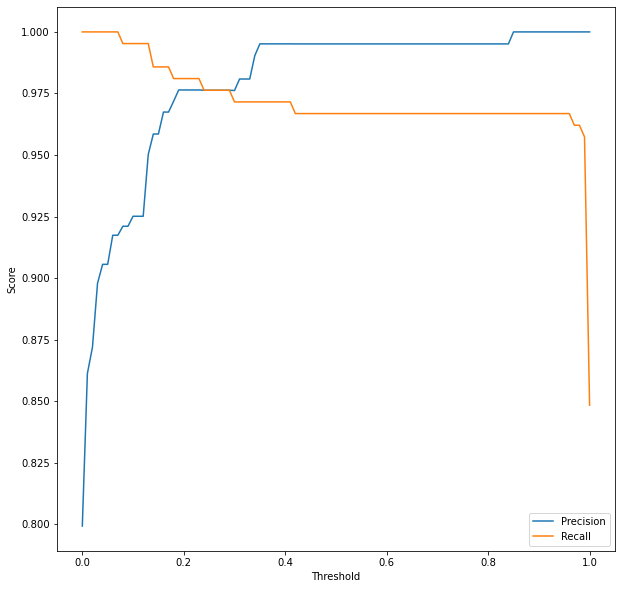

In [65]:
plt.figure(figsize=(10,10))
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()

In [67]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
  _, tp, fp, tn, fn, precision, recall = confusion_matrix_values(y_val, y_val_pred, t)
  f1 = 2 * ((precision * recall) / (precision + recall))
  scores.append((t, tp, fp, fn, tn, precision, recall, f1))

columns =  ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns = columns)

df_scores

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.00,211,53,0,0,0.799242,1.000000,0.888421
1,0.01,211,34,0,19,0.861224,1.000000,0.925439
2,0.02,211,31,0,22,0.871901,1.000000,0.931567
3,0.03,211,24,0,29,0.897872,1.000000,0.946188
4,0.04,211,22,0,31,0.905579,1.000000,0.950450
...,...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,1.000000,0.966825,0.983133
97,0.97,203,0,8,53,1.000000,0.962085,0.980676
98,0.98,203,0,8,53,1.000000,0.962085,0.980676
99,0.99,202,0,9,53,1.000000,0.957346,0.978208


In [70]:
df_scores[['threshold', 'f1']].sort_values(by='f1', ascending=False).iloc[0].threshold.round(1)

0.4

In [73]:
from sklearn.model_selection import KFold

In [139]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [141]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


In [143]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.992 +- 0.006
C= 0.1, 0.995 +- 0.004
C=   1, 0.996 +- 0.003
C=  10, 0.996 +- 0.003
